In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import librosa
import scipy.stats
from scipy.fft import fft
import pandas as pd

# Paths to hit data
parent_folder = '/content/drive/MyDrive/Hammering_Test/s01'
g_hit_path = os.path.join(parent_folder, 'Good_result', 'G_hit')
b_hit_path = os.path.join(parent_folder, 'Bad_result', 'B_hit')

# Output folder for hit features
output_folder = os.path.join(parent_folder, 'Hit_Feature_Result')
os.makedirs(output_folder, exist_ok=True)

# Feature extraction config
num_fft_coeffs = 10
num_mfcc = 13

time_feature_list = []
freq_feature_list = []

# Spectral entropy function
def spectral_entropy(signal):
    fft_vals = np.abs(np.fft.fft(signal))**2
    total_energy = np.sum(fft_vals)
    if total_energy == 0:
        return 0
    energy = fft_vals[:len(fft_vals)//2]
    energy /= total_energy
    entropy = -np.sum(energy * np.log2(energy + 1e-12))
    return entropy

# Feature extraction function
def process_hit_folder(folder_path, label):
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            filepath = os.path.join(folder_path, file)
            y, sr = librosa.load(filepath, sr=None)

            if len(y) < 32:
                continue  # Skip very short files

            N = len(y)
            yf = fft(y)
            magnitude = 2.0 / N * np.abs(yf[:N // 2])

            # ==== Time-Domain Features ====
            time_features = {
                "File": file,
                "Label": label,
                "Mean": np.mean(y),
                "RMS": np.sqrt(np.mean(y**2)),
                "Variance": np.var(y),
                "Skewness": scipy.stats.skew(y),
                "Kurtosis": scipy.stats.kurtosis(y),
                "Crest Factor": np.max(np.abs(y)) / (np.sqrt(np.mean(y**2)) + 1e-10)
            }
            time_feature_list.append(time_features)

            # ==== Frequency-Domain Features ====
            n_fft_val = min(2048, len(y))  # adjust if short
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft_val)[0].mean()
            entropy_val = spectral_entropy(y)

            fft_coeffs = magnitude[:num_fft_coeffs]
            fft_dict = {f"FFT_Coeff_{i+1}": fft_coeffs[i] for i in range(len(fft_coeffs))}

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
            mfcc_means = mfccs.mean(axis=1)
            mfcc_dict = {f"MFCC_{i+1}": mfcc_means[i] for i in range(len(mfcc_means))}

            freq_features = {
                "File": file,
                "Label": label,
                "Spectral Centroid": spectral_centroid,
                "Spectral Entropy": entropy_val
            }
            freq_features.update(fft_dict)
            freq_features.update(mfcc_dict)
            freq_feature_list.append(freq_features)

# Process Good and Bad hit samples
process_hit_folder(g_hit_path, label="Good")
process_hit_folder(b_hit_path, label="Bad")

# Convert to DataFrames
time_df = pd.DataFrame(time_feature_list)
freq_df = pd.DataFrame(freq_feature_list)

# Merge and save
combined_df = pd.merge(time_df, freq_df, on=["File", "Label"])
combined_df.to_csv(os.path.join(output_folder, "combined_all_features_hit_1.csv"), index=False)

print("\n✅ Feature extraction complete!")
print(f"📁 Combined feature CSV saved at: {output_folder}/combined_all_features_hit_1.csv")


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: 


✅ Feature extraction complete!
📁 Combined feature CSV saved at: /content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/combined_all_features_hit_1.csv


In [ ]:
import os
import numpy as np
import librosa
import scipy.stats
from scipy.fft import fft
import pandas as pd

# Paths
parent_folder = '/content/drive/MyDrive/Hammering_Test/s01'
g_hit_path = os.path.join(parent_folder, 'Good_result', 'G_hit')
b_hit_path = os.path.join(parent_folder, 'Bad_result', 'B_hit')

# Output folder
output_folder = os.path.join(parent_folder, 'Hit_Feature_Result')
os.makedirs(output_folder, exist_ok=True)

# Config
num_fft_coeffs = 10
num_mfcc = 13

feature_list = []

# Spectral entropy function
def spectral_entropy(signal):
    fft_vals = np.abs(np.fft.fft(signal))**2
    total_energy = np.sum(fft_vals)
    if total_energy == 0:
        return 0
    energy = fft_vals[:len(fft_vals)//2]
    energy /= total_energy
    entropy = -np.sum(energy * np.log2(energy + 1e-12))
    return entropy

# Dominant frequency function
def dominant_freq(y, sr):
    yf = np.abs(fft(y))
    xf = np.fft.fftfreq(len(y), 1 / sr)
    positive_freqs = xf[:len(xf)//2]
    positive_mags = yf[:len(yf)//2]
    return positive_freqs[np.argmax(positive_mags)]

# Harmonics (approximate using librosa.harmonic)
def harmonic_energy(y):
    y_harmonic, _ = librosa.effects.hpss(y)
    return np.mean(np.abs(y_harmonic))

# Feature extraction function
def process_hit_folder(folder_path, label):
    for file in os.listdir(folder_path):
        if file.endswith('.wav'):
            filepath = os.path.join(folder_path, file)
            y, sr = librosa.load(filepath, sr=None)

            if len(y) < 32:
                continue

            N = len(y)
            yf = fft(y)
            magnitude = 2.0 / N * np.abs(yf[:N // 2])

            # Time-Domain Features
            time_features = {
                "File": file,
                "Label": label,
                "Mean": np.mean(y),
                "RMS": np.sqrt(np.mean(y**2)),
                "Variance": np.var(y),
                "Skewness": scipy.stats.skew(y),
                "Kurtosis": scipy.stats.kurtosis(y),
                "Crest Factor": np.max(np.abs(y)) / (np.sqrt(np.mean(y**2)) + 1e-10),
                "Zero Crossing Rate": librosa.feature.zero_crossing_rate(y)[0].mean()
            }

            # Frequency-Domain Features
            n_fft_val = min(2048, len(y))
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft_val)[0].mean()
            entropy_val = spectral_entropy(y)
            spectral_energy = np.sum(np.square(magnitude))
            dominant = dominant_freq(y, sr)
            harmonic = harmonic_energy(y)

            # FFT Coefficients
            fft_coeffs = magnitude[:num_fft_coeffs]
            fft_dict = {f"FFT_Coeff_{i+1}": fft_coeffs[i] for i in range(len(fft_coeffs))}
            peak_fft_val = np.max(fft_coeffs)
            peak_fft_idx = np.argmax(fft_coeffs) + 1  # 1-based index

            # Chroma
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = chroma.mean(axis=1)
            chroma_dict = {f"Chroma_{i+1}": chroma_mean[i] for i in range(len(chroma_mean))}
            peak_chroma_val = np.max(chroma_mean)
            peak_chroma_idx = np.argmax(chroma_mean) + 1

            # MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
            mfcc_dict = {f"MFCC_{i+1}": mfccs.mean(axis=1)[i] for i in range(num_mfcc)}

            # Combine all features
            all_features = {
                **time_features,
                "Spectral Centroid": spectral_centroid,
                "Spectral Entropy": entropy_val,
                "Spectral Energy": spectral_energy,
                "Dominant Frequency": dominant,
                "Harmonics": harmonic,
                "Peak FFT Value": peak_fft_val,
                "Peak FFT Index": peak_fft_idx,
                "Peak Chroma Value": peak_chroma_val,
                "Peak Chroma Index": peak_chroma_idx,
                **fft_dict,
                **mfcc_dict,
                **chroma_dict
            }

            feature_list.append(all_features)

# Process Good and Bad hits
process_hit_folder(g_hit_path, label="Good")
process_hit_folder(b_hit_path, label="Bad")

# Save all features to one CSV
df = pd.DataFrame(feature_list)
df.to_csv(os.path.join(output_folder, "combined_all_features_hit_final_2.csv"), index=False)

print("\n✅ Final feature extraction complete!")
print(f"📁 CSV saved at: {output_folder}/combined_all_features_hit_final_2.csv")


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(



✅ Final feature extraction complete!
📁 CSV saved at: /content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/combined_all_features_hit_final_2.csv


In [ ]:
import os
import numpy as np
import librosa
import scipy.stats
from scipy.fft import fft
import pandas as pd

# Paths
parent_folder = '/content/drive/MyDrive/Hammering_Test/s01'
g_hit_path = os.path.join(parent_folder, 'Good_result', 'G_hit')
b_hit_path = os.path.join(parent_folder, 'Bad_result', 'B_hit')

# Output folder
output_folder = os.path.join(parent_folder, 'Hit_Feature_Result')
os.makedirs(output_folder, exist_ok=True)

# Config
num_fft_coeffs = 10
num_mfcc = 13
feature_list = []

# Spectral entropy function
def spectral_entropy(signal):
    fft_vals = np.abs(np.fft.fft(signal))**2
    total_energy = np.sum(fft_vals)
    if total_energy == 0:
        return 0
    energy = fft_vals[:len(fft_vals)//2]
    energy /= total_energy
    entropy = -np.sum(energy * np.log2(energy + 1e-12))
    return entropy

# Dominant frequency
def dominant_freq(y, sr):
    yf = np.abs(fft(y))
    xf = np.fft.fftfreq(len(y), 1 / sr)
    positive_freqs = xf[:len(xf)//2]
    positive_mags = yf[:len(yf)//2]
    return positive_freqs[np.argmax(positive_mags)]

# Feature extraction
def process_hit_folder(folder_path, label):
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.wav'):
            filepath = os.path.join(folder_path, file)
            y, sr = librosa.load(filepath, sr=None)

            if len(y) < 32:
                continue

            N = len(y)
            yf = fft(y)
            magnitude = 2.0 / N * np.abs(yf[:N // 2])

            # Time-Domain Features
            time_features = {
                "File": file,
                "Label": 1 if label == "Good" else 0,
                "Mean": np.mean(y),
                "RMS": np.sqrt(np.mean(y**2)),
                "Variance": np.var(y),
                "Skewness": scipy.stats.skew(y),
                "Kurtosis": scipy.stats.kurtosis(y),
                "Crest Factor": np.max(np.abs(y)) / (np.sqrt(np.mean(y**2)) + 1e-10),
                "Zero Crossing Rate": librosa.feature.zero_crossing_rate(y)[0].mean()
            }

            # Frequency-Domain Features
            n_fft_val = min(2048, len(y))
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft_val)[0].mean()
            entropy_val = spectral_entropy(y)
            spectral_energy = np.sum(np.square(magnitude))
            dominant = dominant_freq(y, sr)

            fft_coeffs = magnitude[:num_fft_coeffs]
            fft_dict = {f"FFT_Coeff_{i+1}": fft_coeffs[i] for i in range(len(fft_coeffs))}
            peak_fft_val = np.max(fft_coeffs)
            peak_fft_idx = np.argmax(fft_coeffs) + 1

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
            mfcc_dict = {f"MFCC_{i+1}": mfccs.mean(axis=1)[i] for i in range(num_mfcc)}

            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = chroma.mean(axis=1)
            chroma_dict = {f"Chroma_{i+1}": chroma_mean[i] for i in range(len(chroma_mean))}
            peak_chroma_val = np.max(chroma_mean)
            peak_chroma_idx = np.argmax(chroma_mean) + 1

            # Combine all features
            all_features = {
                **time_features,
                "Spectral Centroid": spectral_centroid,
                "Spectral Entropy": entropy_val,
                "Spectral Energy": spectral_energy,
                "Dominant Frequency": dominant,
                "Peak FFT Value": peak_fft_val,
                "Peak FFT Index": peak_fft_idx,
                "Peak Chroma Value": peak_chroma_val,
                "Peak Chroma Index": peak_chroma_idx,
                **fft_dict,
                **mfcc_dict,
                **chroma_dict
            }

            feature_list.append(all_features)

# Process both folders
process_hit_folder(g_hit_path, label="Good")
process_hit_folder(b_hit_path, label="Bad")

# Save to CSV
df = pd.DataFrame(feature_list)
df = df.sort_values(by="File")  # ensure files are in serial order
df.to_csv(os.path.join(output_folder, "hit_features_final.csv"), index=False)

print("\n✅ Final feature extraction complete!")
print(f"📁 CSV saved at: {output_folder}/hit_features_final.csv")



✅ Final feature extraction complete!
📁 CSV saved at: /content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_final.csv


# Hit Calculations

In [ ]:
import os
import numpy as np
import librosa
import scipy.stats
from scipy.fft import fft
import pandas as pd

# Paths
parent_folder = '/content/drive/MyDrive/Hammering_Test/s01'
g_hit_path = os.path.join(parent_folder, 'Good_result', 'G_hit')
b_hit_path = os.path.join(parent_folder, 'Bad_result', 'B_hit')

# Output folder
output_folder = os.path.join(parent_folder, 'Hit_Feature_Result')
os.makedirs(output_folder, exist_ok=True)

# Config
num_fft_coeffs = 10
num_mfcc = 13
feature_list = []

# Spectral entropy function
def spectral_entropy(signal):
    fft_vals = np.abs(np.fft.fft(signal))**2
    total_energy = np.sum(fft_vals)
    if total_energy == 0:
        return 0
    energy = fft_vals[:len(fft_vals)//2]
    energy /= total_energy
    entropy = -np.sum(energy * np.log2(energy + 1e-12))
    return entropy

# Dominant frequency
def dominant_freq(y, sr):
    yf = np.abs(fft(y))
    xf = np.fft.fftfreq(len(y), 1 / sr)
    positive_freqs = xf[:len(xf)//2]
    positive_mags = yf[:len(yf)//2]
    return positive_freqs[np.argmax(positive_mags)]

# Feature extraction function
def process_hit_folder(folder_path, label):
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.wav'):
            filepath = os.path.join(folder_path, file)
            y, sr = librosa.load(filepath, sr=None)

            if len(y) < 32:
                continue

            N = len(y)
            yf = fft(y)
            magnitude = 2.0 / N * np.abs(yf[:N // 2])

            # Time-Domain Features
            time_features = {
                "File": file,
                "Label": 1 if label == "Good" else 0,
                "Mean": np.mean(y),
                "RMS": np.sqrt(np.mean(y**2)),
                "Variance": np.var(y),
                "Skewness": scipy.stats.skew(y),
                "Kurtosis": scipy.stats.kurtosis(y),
                "Crest Factor": np.max(np.abs(y)) / (np.sqrt(np.mean(y**2)) + 1e-10),
                "Zero Crossing Rate": librosa.feature.zero_crossing_rate(y)[0].mean()
            }

            # Frequency-Domain Features
            n_fft_val = min(2048, len(y))
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft_val)[0].mean()
            entropy_val = spectral_entropy(y)
            spectral_energy = np.sum(np.square(magnitude))
            dominant = dominant_freq(y, sr)

            fft_coeffs = magnitude[:num_fft_coeffs]
            fft_dict = {f"FFT_Coeff_{i+1}": fft_coeffs[i] for i in range(len(fft_coeffs))}
            peak_fft_val = np.max(fft_coeffs)

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
            mfcc_dict = {f"MFCC_{i+1}": mfccs.mean(axis=1)[i] for i in range(num_mfcc)}

            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = chroma.mean(axis=1)
            chroma_dict = {f"Chroma_{i+1}": chroma_mean[i] for i in range(len(chroma_mean))}
            peak_chroma_val = np.max(chroma_mean)

            # Combine all features
            all_features = {
                **time_features,
                "Spectral Centroid": spectral_centroid,
                "Spectral Entropy": entropy_val,
                "Spectral Energy": spectral_energy,
                "Dominant Frequency": dominant,
                "Peak FFT Value": peak_fft_val,
                "Peak Chroma Value": peak_chroma_val,
                **fft_dict,
                **mfcc_dict,
                **chroma_dict
            }

            feature_list.append(all_features)

# Process both folders (Good first, then Bad)
process_hit_folder(g_hit_path, label="Good")
process_hit_folder(b_hit_path, label="Bad")

# Save to CSV
df = pd.DataFrame(feature_list)

# Sort by label: 1 (Good) first, then 0 (Bad), and then by File name
df = df.sort_values(by=["Label", "File"], ascending=[False, True])

# Save to CSV
csv_path = os.path.join(output_folder, "hit_features_final.csv")
df.to_csv(csv_path, index=False)

print("\n✅ Final feature extraction complete!")
print(f"📁 CSV saved at: {csv_path}")



✅ Final feature extraction complete!
📁 CSV saved at: /content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_final.csv


In [ ]:
import os

# Define paths
parent_folder = '/content/drive/MyDrive/Hammering_Test/s01'
g_hit_path = os.path.join(parent_folder, 'Good_result', 'G_hit')
b_hit_path = os.path.join(parent_folder, 'Bad_result', 'B_hit')

# Count .wav files
count_g_hit = len([f for f in os.listdir(g_hit_path) if f.endswith('.wav')])
count_b_hit = len([f for f in os.listdir(b_hit_path) if f.endswith('.wav')])
total = count_g_hit + count_b_hit

# Print results
print(f"✅ G_hit samples: {count_g_hit}")
print(f"✅ B_hit samples: {count_b_hit}")
print(f"📊 Total .wav samples: {total}")


✅ G_hit samples: 3111
✅ B_hit samples: 3190
📊 Total .wav samples: 6301


In [ ]:
import os

# Define paths
parent_folder = '/content/drive/MyDrive/Hammering_Test/s01'
g_hit_path = os.path.join(parent_folder, 'Good_result', 'G_vib')
b_hit_path = os.path.join(parent_folder, 'Bad_result', 'B_vib')

# Count .wav files
count_g_hit = len([f for f in os.listdir(g_hit_path) if f.endswith('.wav')])
count_b_hit = len([f for f in os.listdir(b_hit_path) if f.endswith('.wav')])
total = count_g_hit + count_b_hit

# Print results
print(f"✅ G_vib samples: {count_g_hit}")
print(f"✅ B_vib samples: {count_b_hit}")
print(f"📊 Total .wav samples: {total}")

✅ G_vib samples: 3111
✅ B_vib samples: 3190
📊 Total .wav samples: 6301


# Vibration Calculation

In [ ]:
import os
import numpy as np
import librosa
import scipy.stats
from scipy.fft import fft
import pandas as pd

# Paths
parent_folder = '/content/drive/MyDrive/Hammering_Test/s01'
g_vib_path = os.path.join(parent_folder, 'Good_result', 'G_vib')
b_vib_path = os.path.join(parent_folder, 'Bad_result', 'B_vib')

# Output folder
output_folder = os.path.join(parent_folder, 'Vibration_Feature_Result')
os.makedirs(output_folder, exist_ok=True)

# Config
num_fft_coeffs = 10
num_mfcc = 13
feature_list = []

# Spectral entropy function
def spectral_entropy(signal):
    fft_vals = np.abs(np.fft.fft(signal))**2
    total_energy = np.sum(fft_vals)
    if total_energy == 0:
        return 0
    energy = fft_vals[:len(fft_vals)//2]
    energy /= total_energy
    entropy = -np.sum(energy * np.log2(energy + 1e-12))
    return entropy

# Dominant frequency
def dominant_freq(y, sr):
    yf = np.abs(fft(y))
    xf = np.fft.fftfreq(len(y), 1 / sr)
    positive_freqs = xf[:len(xf)//2]
    positive_mags = yf[:len(yf)//2]
    return positive_freqs[np.argmax(positive_mags)]

# Feature extraction function
def process_vibration_folder(folder_path, label):
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.wav'):
            filepath = os.path.join(folder_path, file)
            y, sr = librosa.load(filepath, sr=None)

            if len(y) < 32:
                continue

            N = len(y)
            yf = fft(y)
            magnitude = 2.0 / N * np.abs(yf[:N // 2])

            # Time-Domain Features
            time_features = {
                "File": file,
                "Label": 1 if label == "Good" else 0,
                "Mean": np.mean(y),
                "RMS": np.sqrt(np.mean(y**2)),
                "Variance": np.var(y),
                "Skewness": scipy.stats.skew(y),
                "Kurtosis": scipy.stats.kurtosis(y),
                "Crest Factor": np.max(np.abs(y)) / (np.sqrt(np.mean(y**2)) + 1e-10),
                "Zero Crossing Rate": librosa.feature.zero_crossing_rate(y)[0].mean()
            }

            # Frequency-Domain Features
            n_fft_val = min(2048, len(y))
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft_val)[0].mean()
            entropy_val = spectral_entropy(y)
            spectral_energy = np.sum(np.square(magnitude))
            dominant = dominant_freq(y, sr)

            fft_coeffs = magnitude[:num_fft_coeffs]
            fft_dict = {f"FFT_Coeff_{i+1}": fft_coeffs[i] for i in range(len(fft_coeffs))}
            peak_fft_val = np.max(fft_coeffs)

            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
            mfcc_dict = {f"MFCC_{i+1}": mfccs.mean(axis=1)[i] for i in range(num_mfcc)}

            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = chroma.mean(axis=1)
            chroma_dict = {f"Chroma_{i+1}": chroma_mean[i] for i in range(len(chroma_mean))}
            peak_chroma_val = np.max(chroma_mean)

            # Combine all features
            all_features = {
                **time_features,
                "Spectral Centroid": spectral_centroid,
                "Spectral Entropy": entropy_val,
                "Spectral Energy": spectral_energy,
                "Dominant Frequency": dominant,
                "Peak FFT Value": peak_fft_val,
                "Peak Chroma Value": peak_chroma_val,
                **fft_dict,
                **mfcc_dict,
                **chroma_dict
            }

            feature_list.append(all_features)

# Process both folders (Good first, then Bad)
process_vibration_folder(g_vib_path, label="Good")
process_vibration_folder(b_vib_path, label="Bad")

# Save to CSV
df = pd.DataFrame(feature_list)

# Sort: Good (1) first, then Bad (0), then by file name
df = df.sort_values(by=["Label", "File"], ascending=[False, True])

# Save to CSV
csv_path = os.path.join(output_folder, "vibration_features_final.csv")
df.to_csv(csv_path, index=False)

print("\n✅ Vibration feature extraction complete!")
print(f"📁 CSV saved at: {csv_path}")


<ipython-input-8-3154727129>:62: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "Skewness": scipy.stats.skew(y),
<ipython-input-8-3154727129>:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "Kurtosis": scipy.stats.kurtosis(y),



✅ Vibration feature extraction complete!
📁 CSV saved at: /content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_final.csv


#Normalization using Z-Score Standardization

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your dataset
csv_path = '/content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_final.csv'  # or vibration_features_final.csv
df = pd.read_csv(csv_path)

# Columns to keep untouched
non_feature_cols = ['File', 'Label']

# Extract features and apply normalization
features = df.drop(columns=non_feature_cols)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Rebuild normalized DataFrame
df_normalized = pd.DataFrame(features_scaled, columns=features.columns)
df_normalized[non_feature_cols] = df[non_feature_cols]  # Add back file and label

# Reorder columns
df_normalized = df_normalized[non_feature_cols + list(features.columns)]

# Save normalized dataset
normalized_csv_path = csv_path.replace('.csv', '_normalized.csv')
df_normalized.to_csv(normalized_csv_path, index=False)

print("✅ Normalization complete!")
print(f"📁 Normalized file saved at: {normalized_csv_path}")


✅ Normalization complete!
📁 Normalized file saved at: /content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_final_normalized.csv


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your dataset
csv_path = '/content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_final.csv'  # or vibration_features_final.csv
df = pd.read_csv(csv_path)

# Columns to keep untouched
non_feature_cols = ['File', 'Label']

# Extract features and apply normalization
features = df.drop(columns=non_feature_cols)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Rebuild normalized DataFrame
df_normalized = pd.DataFrame(features_scaled, columns=features.columns)
df_normalized[non_feature_cols] = df[non_feature_cols]  # Add back file and label

# Reorder columns
df_normalized = df_normalized[non_feature_cols + list(features.columns)]

# Save normalized dataset
normalized_csv_path = csv_path.replace('.csv', '_normalized.csv')
df_normalized.to_csv(normalized_csv_path, index=False)

print("✅ Normalization complete!")
print(f"📁 Normalized file saved at: {normalized_csv_path}")

✅ Normalization complete!
📁 Normalized file saved at: /content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_final_normalized.csv


#Feature Selection for HIT

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# === Step 1: Load dataset ===
df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_final_normalized.csv")

# Separate features and labels
features = df.drop(columns=["Label", "File"])
labels = df["Label"]
files = df["File"]

# === Step 2: Normalize the features ===
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# === Step 3: Feature Selection using Random Forest ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(features_scaled, labels)

# Select top features above median importance
selector = SelectFromModel(clf, threshold='median', prefit=True)
selected_features = selector.transform(features_scaled)
selected_feature_names = features.columns[selector.get_support()]

# === Step 4: Create DataFrame with selected features ===
reduced_df = pd.DataFrame(selected_features, columns=selected_feature_names)
reduced_df['Label'] = labels
reduced_df['File'] = files

# === Step 5: Save the reduced dataset ===
output_path = "/content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_selected.csv"
reduced_df.to_csv(output_path, index=False)

print("✅ Feature selection complete.")
print(f"📁 Selected features saved at: {output_path}")
print(f"🎯 Number of selected features: {len(selected_feature_names)}")


✅ Feature selection complete.
📁 Selected features saved at: /content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_selected.csv
🎯 Number of selected features: 24


#Feature selection of Vibrations

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# === Step 1: Load vibration dataset ===
df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_final_normalized.csv")

# Separate features and labels
features = df.drop(columns=["Label", "File"])
labels = df["Label"]
files = df["File"]

# === Step 2: Normalize the features ===
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# === Step 3: Feature Selection using Random Forest ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(features_scaled, labels)

# Select top features above median importance
selector = SelectFromModel(clf, threshold='median', prefit=True)
selected_features = selector.transform(features_scaled)
selected_feature_names = features.columns[selector.get_support()]

# === Step 4: Create DataFrame with selected features ===
reduced_df = pd.DataFrame(selected_features, columns=selected_feature_names)
reduced_df['Label'] = labels
reduced_df['File'] = files

# === Step 5: Save the reduced dataset ===
output_path = "/content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_selected.csv"
reduced_df.to_csv(output_path, index=False)

print("✅ Feature selection for vibration data complete.")
print(f"📁 Selected features saved at: {output_path}")
print(f"🎯 Number of selected features: {len(selected_feature_names)}")


✅ Feature selection for vibration data complete.
📁 Selected features saved at: /content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_selected.csv
🎯 Number of selected features: 24



🔍 Processing: Hit Data


<ipython-input-23-572933478>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(TOP_N), palette="coolwarm")


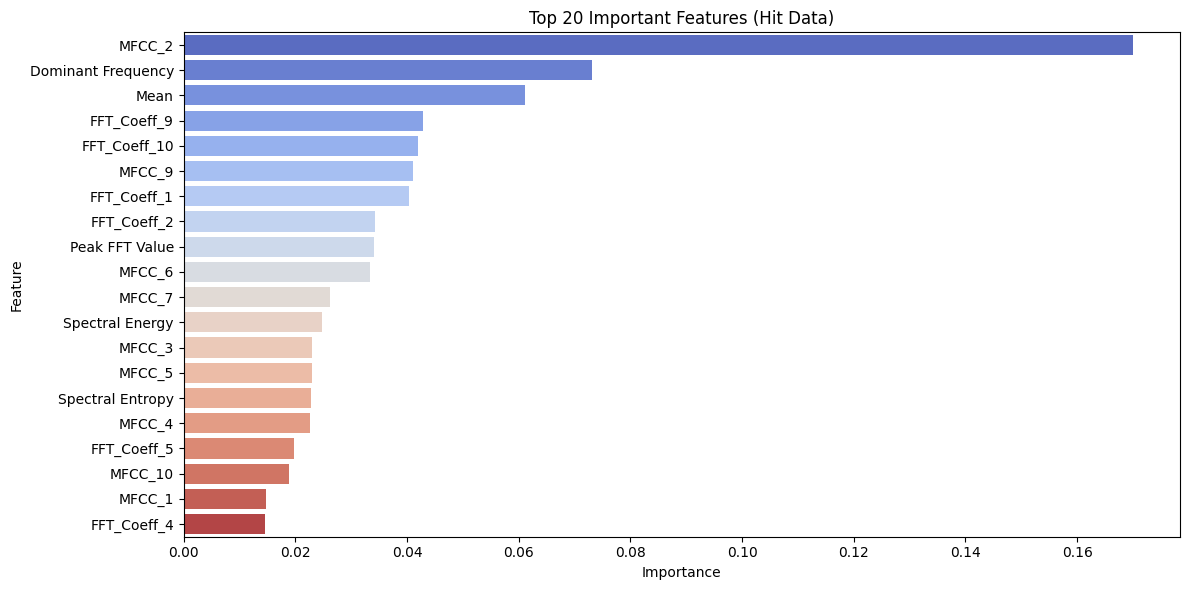


🔍 Processing: Vibration Data


<ipython-input-23-572933478>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df.head(TOP_N), palette="coolwarm")


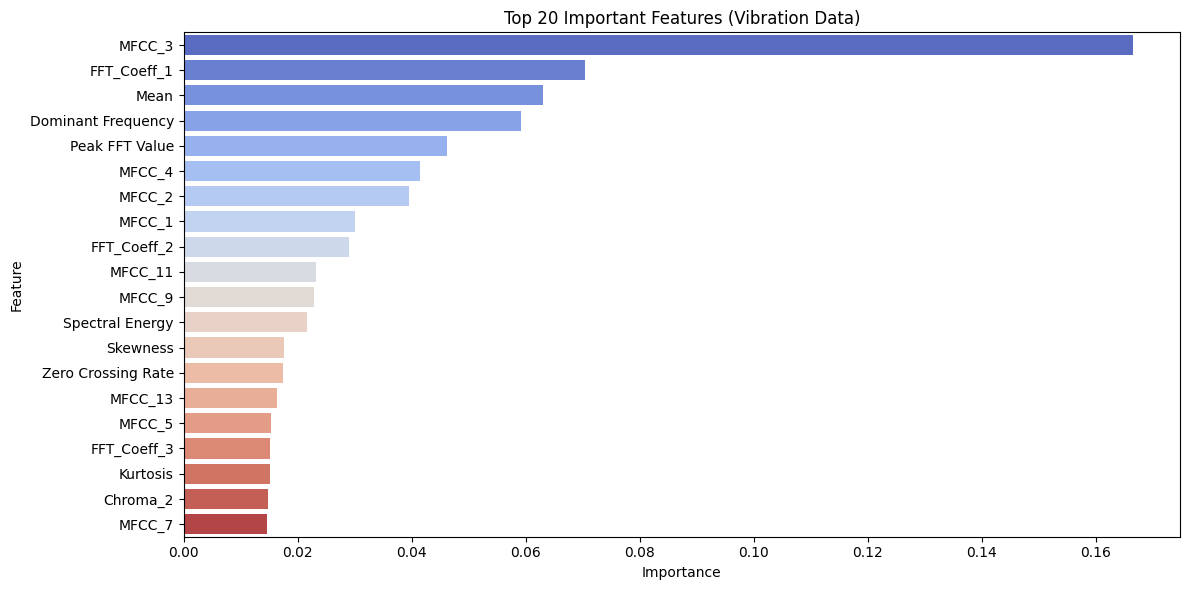

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# === CONFIG ===
TOP_N = 20
base_path = "/content/drive/MyDrive/Hammering_Test/s01"

# === FUNCTION TO PROCESS AND PLOT ===
def feature_selection_plot(csv_path, dataset_name):
    print(f"\n🔍 Processing: {dataset_name}")

    # Load dataset
    df = pd.read_csv(csv_path)

    # Separate features and labels
    features = df.drop(columns=["Label", "File"])
    labels = df["Label"]

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(features_scaled, labels)

    # Extract importances
    importances = clf.feature_importances_
    feature_names = features.columns

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Plot Top N
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(TOP_N), palette="coolwarm")
    plt.title(f"Top {TOP_N} Important Features ({dataset_name})")
    plt.tight_layout()
    plt.show()

    return importance_df.head(TOP_N)

# === RUN FOR HIT DATA ===
hit_csv = f"{base_path}/Hit_Feature_Result/hit_features_final_normalized.csv"
top_hit_features = feature_selection_plot(hit_csv, "Hit Data")

# === RUN FOR VIBRATION DATA ===
vib_csv = f"{base_path}/Vibration_Feature_Result/vibration_features_final_normalized.csv"
top_vib_features = feature_selection_plot(vib_csv, "Vibration Data")


#model training for Hits

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# === Step 1: Load the dataset ===
df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_selected.csv")

# === Step 2: Separate features and labels ===
X = df.drop(columns=["Label", "File"])
y = df["Label"]

# === Step 3: Handle Missing Values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# === Step 4: Scale Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 5: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Step 6: Define Models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier()
}

# === Step 7: Train and Evaluate ===
for name, model in models.items():
    print(f"\n🔍 Evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("✅ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Classification Report:\n", classification_report(y_test, y_pred))
    print("🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔍 Evaluating: Logistic Regression
✅ Accuracy: 0.9008723235527359
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90       639
           1       0.91      0.89      0.90       622

    accuracy                           0.90      1261
   macro avg       0.90      0.90      0.90      1261
weighted avg       0.90      0.90      0.90      1261

🧮 Confusion Matrix:
 [[582  57]
 [ 68 554]]

🔍 Evaluating: Random Forest
✅ Accuracy: 0.9429024583663759
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       639
           1       0.94      0.95      0.94       622

    accuracy                           0.94      1261
   macro avg       0.94      0.94      0.94      1261
weighted avg       0.94      0.94      0.94      1261

🧮 Confusion Matrix:
 [[598  41]
 [ 31 591]]

🔍 Evaluating: Gradient Boosting
✅ Accuracy: 0.9357652656621729
📊 Classification

# model Training for vibration

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# === Step 1: Load the dataset ===
df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_selected.csv")

# === Step 2: Separate features and labels ===
X = df.drop(columns=["Label", "File"])
y = df["Label"]

# === Step 3: Handle Missing Values ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# === Step 4: Scale Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 5: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === Step 6: Define Models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier()
}

# === Step 7: Train and Evaluate ===
for name, model in models.items():
    print(f"\n🔍 Evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("✅ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Classification Report:\n", classification_report(y_test, y_pred))
    print("🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))




🔍 Evaluating: Logistic Regression
✅ Accuracy: 0.8810467882632831
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       639
           1       0.89      0.86      0.88       622

    accuracy                           0.88      1261
   macro avg       0.88      0.88      0.88      1261
weighted avg       0.88      0.88      0.88      1261

🧮 Confusion Matrix:
 [[574  65]
 [ 85 537]]

🔍 Evaluating: Random Forest
✅ Accuracy: 0.9175257731958762
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       639
           1       0.94      0.89      0.91       622

    accuracy                           0.92      1261
   macro avg       0.92      0.92      0.92      1261
weighted avg       0.92      0.92      0.92      1261

🧮 Confusion Matrix:
 [[603  36]
 [ 68 554]]

🔍 Evaluating: Gradient Boosting
✅ Accuracy: 0.9127676447264076
📊 Classification

#Convolutional Neural Network Training

**📦 1. Import Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


**📁 2. Load and Combine Hit + Vibration Datasets**

In [ ]:
# Load the selected features from both CSVs
hit_df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_selected.csv")
vib_df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_selected.csv")

# Sort both by File to align rows (important)
hit_df = hit_df.sort_values(by="File").reset_index(drop=True)
vib_df = vib_df.sort_values(by="File").reset_index(drop=True)

# Ensure Labels match
assert (hit_df["Label"] == vib_df["Label"]).all(), "Mismatch in labels!"

# Concatenate features
combined_features = pd.concat([hit_df.drop(columns=["Label", "File"]),
                               vib_df.drop(columns=["Label", "File"])], axis=1)

# Use the same Label and File columns
labels = hit_df["Label"]
files = hit_df["File"]


**⚙️ 3. Preprocess Data**

In [ ]:
# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(combined_features)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Reshape for CNN: [samples, features, 1]
X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# One-hot encode labels
y = to_categorical(labels, num_classes=2)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)


**🧠 4. Define and Compile CNN Model**

In [ ]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Binary classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,842 (421.26 KB)

 Trainable params: 107,458 (419.76 KB)

 Non-trainable params: 384 (1.50 KB)

**🚀 5. Train the Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)


Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8812 - loss: 0.3702 - val_accuracy: 0.9355 - val_loss: 0.1459
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9487 - loss: 0.1191 - val_accuracy: 0.9603 - val_loss: 0.0895
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9566 - loss: 0.1068 - val_accuracy: 0.9643 - val_loss: 0.0875
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9654 - loss: 0.0799 - val_accuracy: 0.9633 - val_loss: 0.1017
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9634 - loss: 0.0899 - val_accuracy: 0.9603 - val_loss: 0.0889
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9650 - loss: 0.0688 - val_accuracy: 0.9702 - val_loss: 0.0779
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9697 - loss: 0.0652 - val_accuracy: 0.9633 - val_loss: 0.0938
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9735 - loss: 0.0563 - val_accuracy: 0.

**📊 6. Evaluate the Model**

In [ ]:
# Predict
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
print("📊 Classification Report:\n", classification_report(y_true, y_pred_classes))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96       629
           1       0.94      0.99      0.96       632

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261

🧮 Confusion Matrix:
 [[590  39]
 [  8 624]]


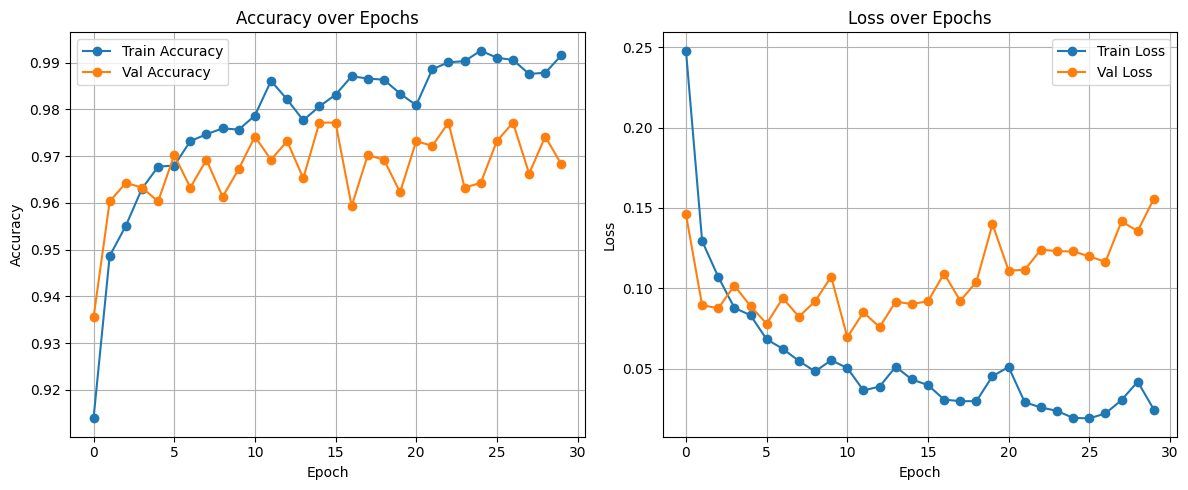

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call after training
plot_training_curves(history)



# Second Run Test for the model improvization

**📦 1. Imports**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


**📁 2. Load and Combine Features**

In [ ]:
# Load CSVs
hit_df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_selected.csv")
vib_df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_selected.csv")

# Align by filename
hit_df = hit_df.sort_values(by="File").reset_index(drop=True)
vib_df = vib_df.sort_values(by="File").reset_index(drop=True)

assert (hit_df["Label"] == vib_df["Label"]).all(), "Mismatch in labels!"

# Concatenate features
combined_features = pd.concat([
    hit_df.drop(columns=["Label", "File"]),
    vib_df.drop(columns=["Label", "File"])
], axis=1)

labels = hit_df["Label"]


**⚙️ 3. Preprocessing**

In [ ]:
# Handle NaNs
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(combined_features)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Reshape for CNN
X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# One-hot encode labels
y = to_categorical(labels, num_classes=2)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42, stratify=labels)


**🧠 4. CNN Model (Improved)**

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 46, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,098 (422.26 KB)

 Trainable params: 107,586 (420.26 KB)

 Non-trainable params: 512 (2.00 KB)

**🚀 5. Train Model with Callbacks**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7237 - loss: 0.7335 - val_accuracy: 0.8016 - val_loss: 0.4267 - learning_rate: 1.0000e-04
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8288 - loss: 0.5148 - val_accuracy: 0.9048 - val_loss: 0.2416 - learning_rate: 1.0000e-04
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8650 - loss: 0.3895 - val_accuracy: 0.9127 - val_loss: 0.2123 - learning_rate: 1.0000e-04
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8739 - loss: 0.3493 - val_accuracy: 0.9117 - val_loss: 0.1998 - learning_rate: 1.0000e-04
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8710 - loss: 0.3390 - val_accuracy: 0.9246 - val_loss: 0.1778 - learning_rate: 1.0000e-04
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8847 - loss: 0.3025 - val_accuracy: 0.9276 - val_loss: 0.1697 - learning_rate: 1.0000e-04
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 

**📈 6. Training Curve Visualization**

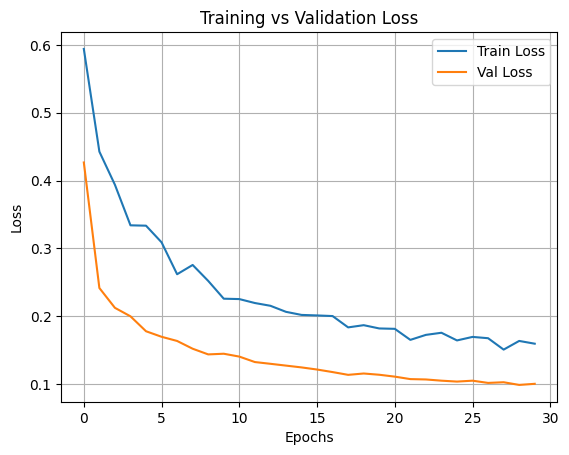

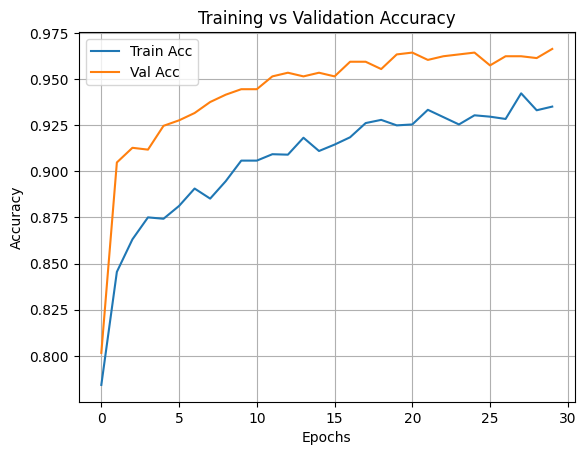

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend(); plt.grid(); plt.show()

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(); plt.grid(); plt.show()

**📊 7. Evaluation**

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       638
           1       0.96      0.96      0.96       623

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261



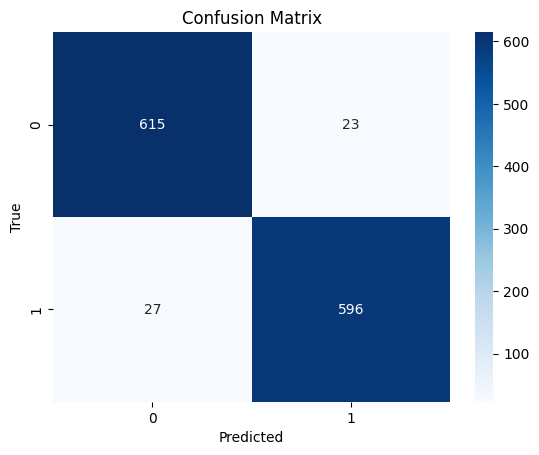

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("📊 Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


** 8. Model Saving / Loading**

In [ ]:
model.save("brick_cnn_model.h5")

# To load later:
# model = load_model("brick_cnn_model.h5")

# 3rd run for the CNNs model output results

**1. Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


**📁 2. Load and Combine Hit + Vibration Features**

In [ ]:
# Load feature CSVs
hit_df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Hit_Feature_Result/hit_features_selected.csv")
vib_df = pd.read_csv("/content/drive/MyDrive/Hammering_Test/s01/Vibration_Feature_Result/vibration_features_selected.csv")

# Sort to align rows
hit_df = hit_df.sort_values(by="File").reset_index(drop=True)
vib_df = vib_df.sort_values(by="File").reset_index(drop=True)

# Check labels match
assert (hit_df["Label"] == vib_df["Label"]).all(), "Mismatch in labels!"

# Combine features (drop file and label columns)
X = pd.concat([
    hit_df.drop(columns=["Label", "File"]),
    vib_df.drop(columns=["Label", "File"])
], axis=1)

# Labels
y = hit_df["Label"]


**⚙️ 3. Preprocess Data**

In [ ]:
# Handle NaNs
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Reshape for CNN input
X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# One-hot encode labels
y_cat = to_categorical(y, num_classes=2)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_cat, test_size=0.2, stratify=y, random_state=42
)


**🧠 4. Define CNN Model (Improved)**

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(2, activation='softmax')  # Binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 46, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,074 (418.26 KB)

 Trainable params: 107,074 (418.26 KB)

 Non-trainable params: 0 (0.00 B)

**🚀 5. Train Model with Callbacks**

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7276 - loss: 0.5847 - val_accuracy: 0.8621 - val_loss: 0.3739 - learning_rate: 1.0000e-04
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8693 - loss: 0.3554 - val_accuracy: 0.8780 - val_loss: 0.3158 - learning_rate: 1.0000e-04
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8885 - loss: 0.3115 - val_accuracy: 0.8889 - val_loss: 0.2808 - learning_rate: 1.0000e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8875 - loss: 0.2873 - val_accuracy: 0.9008 - val_loss: 0.2588 - learning_rate: 1.0000e-04
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8985 - loss: 0.2544 - val_accuracy: 0.9048 - val_loss: 0.2413 - learning_rate: 1.0000e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9031 - loss: 0.2455 - val_accuracy: 0.9087 - val_loss: 0.2208 - learning_rate: 1.0000e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc

**📈 6. Visualize Training Curves**

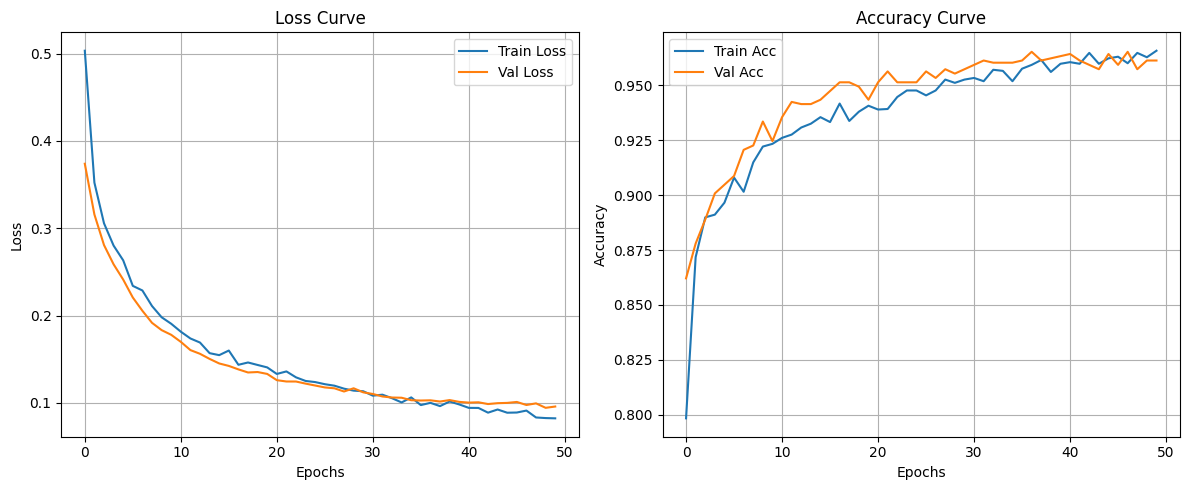

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Loss Curve')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve')
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()


**📊 7. Model Evaluation**

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       638
           1       0.96      0.96      0.96       623

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261



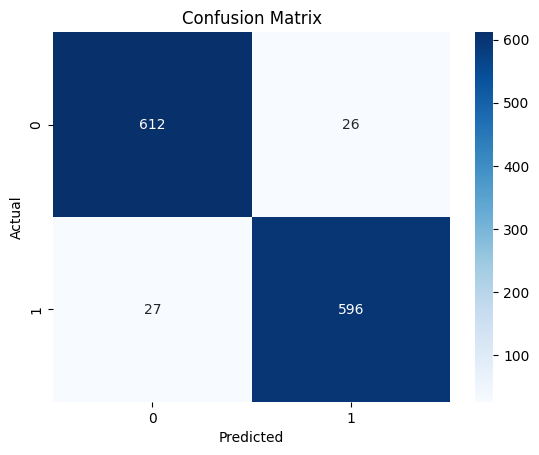

In [ ]:
# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
print("📊 Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(2, activation='softmax')  # Binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 46, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,074 (418.26 KB)

 Trainable params: 107,074 (418.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7450 - loss: 0.5813 - val_accuracy: 0.8661 - val_loss: 0.3620 - learning_rate: 1.0000e-04
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8748 - loss: 0.3476 - val_accuracy: 0.8829 - val_loss: 0.3075 - learning_rate: 1.0000e-04
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8721 - loss: 0.3322 - val_accuracy: 0.8919 - val_loss: 0.2793 - learning_rate: 1.0000e-04
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9021 - loss: 0.2805 - val_accuracy: 0.9028 - val_loss: 0.2578 - learning_rate: 1.0000e-04
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8910 - loss: 0.2696 - val_accuracy: 0.9087 - val_loss: 0.2354 - learning_rate: 1.0000e-04
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9070 - loss: 0.2361 - val_accuracy: 0.9117 - val_loss: 0.2201 - learning_rate: 1.0000e-04
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/ste

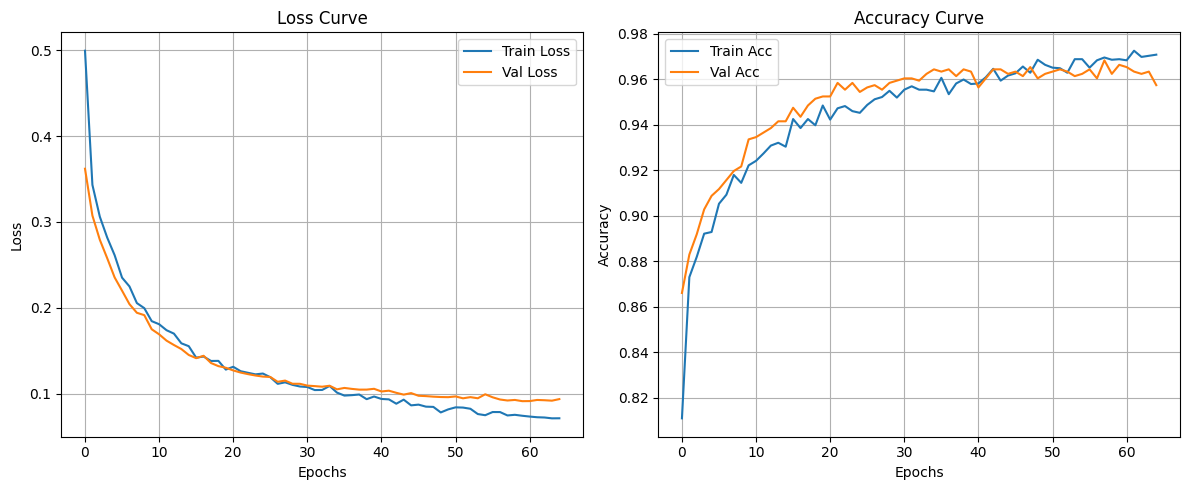

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Loss Curve')
plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve')
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       638
           1       0.96      0.95      0.95       623

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261



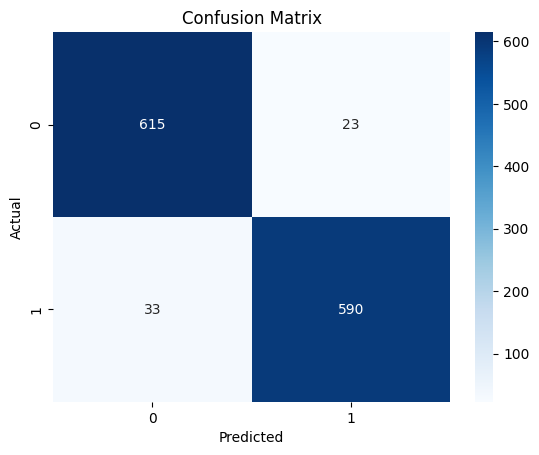

In [ ]:
# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
print("📊 Classification Report:\n", classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()